# CNN Classifier 

the CNN implementation using ensemble model

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=15):
        super(CNN, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(8)

        # Conv Block 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        self.bn2   = nn.BatchNorm2d(16)

        # Conv Block 3
        self.conv3 = nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=3)
        self.bn3   = nn.BatchNorm2d(32)

        # Conv Block 4
        self.conv4 = nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3)
        self.bn4   = nn.BatchNorm2d(32)

        # Conv Block 5
        self.conv5 = nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3)
        self.bn5   = nn.BatchNorm2d(32)

        # Dropouts
        self.drop_conv = nn.Dropout2d(p=0.05)   # light dropout after conv blocks
        self.drop_fc   = nn.Dropout(p=0.1)     # strong dropout before FC

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)

        # 64→32→16 spatial resolution
        self.fc = nn.Linear(32 * 16 * 16, num_classes)


    def forward(self, x):

        # BLOCK 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)              # pool only on first two blocks
        x = self.drop_conv(x)

        # BLOCK 2
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        # BLOCK 3
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.drop_conv(x)

        # BLOCK 4
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.drop_conv(x)

        # BLOCK 5
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.drop_conv(x)

        # FC
        x = x.view(x.size(0), -1)
        x = self.drop_fc(x)           # strong dropout before classification
        x = self.fc(x)

        return x


# Training helper
def train_one_epoch(model, loader, criterion, optimizer, device):

    model.train()
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
    
        inputs, targets = inputs.to(device), targets.to(device)
    
        optimizer.zero_grad() # Zero the parameter gradients
    
        outputs = model(inputs) # Forward pass
    
        loss = criterion(outputs, targets) # Compute loss
    
        loss.backward() # Backward pass
    
        optimizer.step() # Optimize weights

        total_loss += loss.item() * inputs.size(0) # Accumulate loss
        
        _, preds = outputs.max(1) # Get predictions
        
        correct += preds.eq(targets).sum().item() # Count correct predictions
        
        total += targets.size(0) # Count total samples
    
    return total_loss / total, correct / total # Return average loss and accuracy

# Evaluation helper
def evaluate(model, loader, criterion, device):

    model.eval() # Set model to evaluation mode
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
    
        for inputs, targets in loader:
    
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
            
    return total_loss / total, correct / total


In [4]:
# Set the path to your dataset and parameters
data_root = Path('/Users/leonardoangellotti/Desktop/universita/Comp_Vision/CNN/data_augmented')
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define class names
class_names = ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity',
               'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry',
               'Store', 'Street', 'Suburb', 'TallBuilding']

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load datasets
train_dir = data_root / 'train'
val_dir = data_root / 'val'
test_dir = data_root / 'test'

train_dataset = datasets.ImageFolder(str(train_dir), transform=transform)

if val_dir.exists():
    val_dataset = datasets.ImageFolder(str(val_dir), transform=transform)
else:
    total_train = len(train_dataset)
    val_size = int(0.15 * total_train)
    train_size = total_train - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(42))

test_dataset = datasets.ImageFolder(str(test_dir), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Using device: cpu


In [5]:
# Number of training samples
print("Number of training images:", len(train_dataset))

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)
print("Batch label tensor shape:", labels.shape)

# Inspect one image
print("Single image shape:", images[0].shape)


Number of training images: 5100
Batch image tensor shape: torch.Size([32, 1, 64, 64])
Batch label tensor shape: torch.Size([32])
Single image shape: torch.Size([1, 64, 64])


In [5]:
num_epochs = 12
learning_rate = 0.01
momentum = 0.9

In [ ]:
num_ensembles = 4
# Number of separate models to train in the ensemble

# Containers to store history for each model (optional)
all_train_losses, all_val_losses = [], []
# all_train_losses: list of train loss curves (one list per model)
# all_val_losses: list of val loss curves (one list per model)

all_train_accs, all_val_accs = [], []
# all_train_accs: list of train accuracy curves (one list per model)
# all_val_accs: list of val accuracy curves (one list per model)


# To store trained models
ensemble_models = []
# This list will contain the 'num_ensembles' trained models


for m in range(num_ensembles):
    # Loop over each ensemble member index m = 0,1,...,num_ensembles-1

    print(f"\n=== Training model {m+1}/{num_ensembles} ===")
    # Informative print: which model (1-based index) we are training

    model = CNN(num_classes=len(class_names)).to(device)
    # Create a fresh CNN instance for this ensemble member and move it to CPU/GPU

    criterion = nn.CrossEntropyLoss()
    # Loss function for multi-class classification

    optimizer = torch.optim.Adam(
        model.parameters(),       # Optimize the parameters of this model
        lr=learning_rate,         # Learning rate for Adam
        betas=(0.9, 0.999),       # Default Adam betas (momentum-like parameters)
        weight_decay=0            # No L2 regularization
    )

    train_losses, val_losses = [], []
    # Per-model list to store training and validation loss over epochs

    train_accs, val_accs = [], []
    # Per-model list to store training and validation accuracy over epochs

    best_val_loss = float('inf')
    # Initialize best validation loss for early stopping (start very large)

    patience, patience_counter = 10, 0
    # Early stopping patience (how many epochs without improvement before stopping)
    # patience_counter counts consecutive non-improving epochs

    best_model_path = f"best_model_{m}.pth"
    # File name where the best checkpoint for this particular model will be saved

    for epoch in range(1, num_epochs + 1):
        # Main training loop for this model over epochs

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        # Train the model for one epoch on the training set and get average loss & accuracy

        val_loss, val_acc = evaluate(
            model, val_loader, criterion, device
        )
        # Evaluate the model on the validation set and get avg loss & accuracy

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # Store this epoch's train and validation loss

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # Store this epoch's train and validation accuracy


        # Print metrics for this epoch and this specific ensemble model
        print(
            f'Model {m+1}, Epoch {epoch}/{num_epochs} - '
            f'train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, '
            f'val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
        )
        
        # Early stopping
        if val_loss < best_val_loss:
            # If validation loss improved:

            best_val_loss = val_loss
            # Update best validation loss

            patience_counter = 0
            # Reset patience counter since performance improved

            torch.save(model.state_dict(), best_model_path)
            # Save the current model weights as the best for this ensemble member

        else:
            # If validation loss did NOT improve:

            patience_counter += 1
            # Increase the patience counter

            if patience_counter >= patience:
                # If we've gone 'patience' epochs without improvement:

                print('Early stopping triggered for this model.')
                # Notify that early stopping has been triggered

                break
                # Stop training further epochs for this ensemble member


    # Load best weights for this model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    # Restore the model parameters from the best checkpoint saved during training

    ensemble_models.append(model)
    # Add this fully trained (best version) model to the ensemble list


    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    # Save the history of train/val loss curves for this model

    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)
    # Save the history of train/val accuracy curves for this model



=== Training model 1/5 ===
Model 1, Epoch 1/12 - train_loss: 4.2124, train_acc: 0.1625, val_loss: 2.3571, val_acc: 0.2933
Model 1, Epoch 2/12 - train_loss: 2.2089, train_acc: 0.2873, val_loss: 2.4957, val_acc: 0.2267
Model 1, Epoch 3/12 - train_loss: 2.0036, train_acc: 0.3555, val_loss: 1.7101, val_acc: 0.4578
Model 1, Epoch 4/12 - train_loss: 1.7972, train_acc: 0.4239, val_loss: 1.8789, val_acc: 0.3778
Model 1, Epoch 5/12 - train_loss: 1.5975, train_acc: 0.4859, val_loss: 2.1909, val_acc: 0.3511
Model 1, Epoch 6/12 - train_loss: 1.4142, train_acc: 0.5408, val_loss: 1.8209, val_acc: 0.4267
Model 1, Epoch 7/12 - train_loss: 1.2519, train_acc: 0.5904, val_loss: 1.5781, val_acc: 0.5067
Model 1, Epoch 8/12 - train_loss: 1.1173, train_acc: 0.6278, val_loss: 1.8386, val_acc: 0.4178
Model 1, Epoch 9/12 - train_loss: 1.0035, train_acc: 0.6773, val_loss: 1.5927, val_acc: 0.5111
Model 1, Epoch 10/12 - train_loss: 0.8952, train_acc: 0.7041, val_loss: 1.5229, val_acc: 0.5467
Model 1, Epoch 11/12 

: 

In [8]:
# append .pth models from folder
ensemble_models = []
model_files = [f for f in os.listdir('ensemble') if f.endswith('.pth')]
for model_file in model_files:
    model_path = os.path.join('ensemble', model_file)
    model = CNN(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    ensemble_models.append(model)
print(f"Loaded {len(ensemble_models)} models for ensemble evaluation.")

Loaded 4 models for ensemble evaluation.


Ensemble Test Accuracy: 54.94%


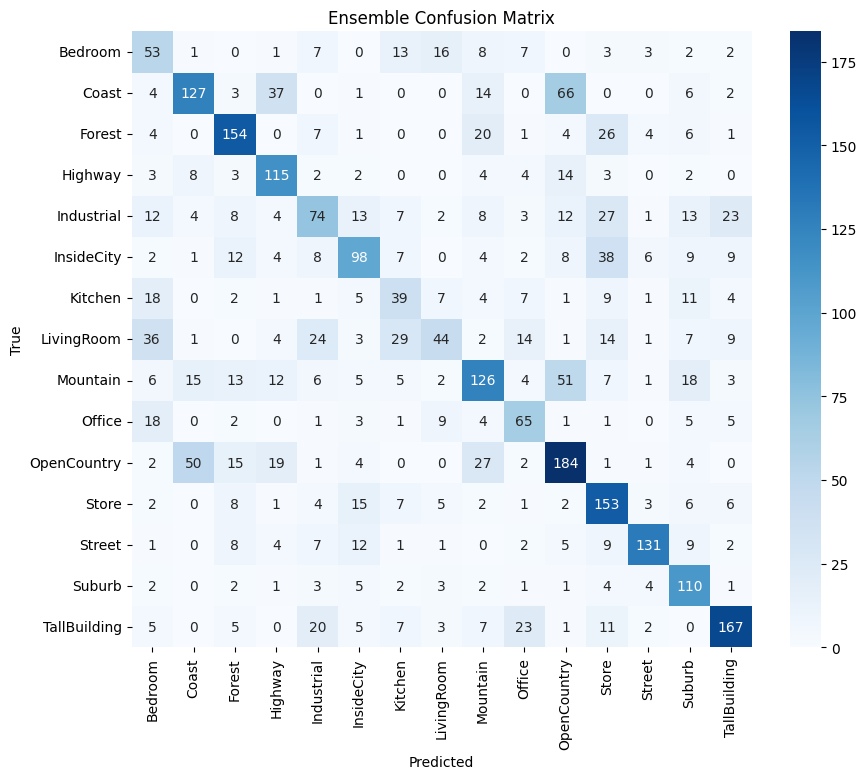

In [9]:
def ensemble_predict(models, inputs, device):
    with torch.no_grad():                          # Disable gradient computation for speed + memory
        logits_sum = None                          # Will hold the sum of logits from all models
        
        for model in models:                       # Loop through each trained ensemble member
            model.eval()                           # Set model to evaluation mode (dropout/BN fixed)
            
            outputs = model(inputs.to(device))     # Forward pass: compute logits for this model
            
            if logits_sum is None:                 # If this is the first model:
                logits_sum = outputs               # Initialize logits_sum with this model's logits
            else:
                logits_sum += outputs              # Accumulate logits from all ensemble models
        
        return logits_sum / len(models)            # Return the averaged logits across ensemble

# Evaluate ensemble and compute confusion matrix
all_preds, all_targets = [], []                    # Lists to store all predictions and labels

with torch.no_grad():                              # No gradients needed for evaluation
    for inputs, targets in test_loader:            # Loop through test dataset batches
        
        inputs, targets = inputs.to(device), targets.to(device)  
        # Move batch to GPU/CPU
        
        avg_logits = ensemble_predict(ensemble_models, inputs, device)
        # Get averaged logits from ensemble
        
        _, preds = avg_logits.max(1)               # Convert logits to predicted class indices
        
        all_preds.extend(preds.cpu().numpy())      # Add predictions to list (move to CPU first)
        all_targets.extend(targets.cpu().numpy())  # Add true labels to list


# Ensemble accuracy
ensemble_test_acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f"Ensemble Test Accuracy: {ensemble_test_acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix')
plt.show()